In [1]:
!pip install future

In [83]:
from __future__ import print_function,division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [84]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [85]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding ="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [86]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("toxic_comments/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments...


In [87]:
print('max sequence length:',max(len(s) for s in sentences))

max sequence length: 5000


In [88]:
print('min sequence length:',min(len(s) for s in sentences))

min sequence length: 6


In [89]:
s = sorted(len(s) for s in sentences)
print('median sequence length:',s[len(s)//2])

median sequence length: 205


In [90]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [91]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [92]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [93]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [94]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [95]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [96]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building model...


In [97]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


In [98]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 69s 543us/step - loss: 0.0844 - acc: 0.9729 - val_loss: 0.0808 - val_acc: 0.9728
Epoch 2/10
127656/127656 [==============================] - 75s 591us/step - loss: 0.0673 - acc: 0.9773 - val_loss: 0.0685 - val_acc: 0.9772
Epoch 3/10
127656/127656 [==============================] - 76s 598us/step - loss: 0.0622 - acc: 0.9788 - val_loss: 0.0674 - val_acc: 0.9775
Epoch 4/10
127656/127656 [==============================] - 76s 599us/step - loss: 0.0590 - acc: 0.9796 - val_loss: 0.0687 - val_acc: 0.9779
Epoch 5/10
127656/127656 [==============================] - 77s 601us/step - loss: 0.0564 - acc: 0.9803 - val_loss: 0.0688 - val_acc: 0.9780
Epoch 6/10
127656/127656 [==============================] - 77s 606us/step - loss: 0.0541 - acc: 0.9809 - val_loss: 0.0700 - val_acc: 0.9769
Epoch 7/10
127656/127656 [==============================] - 77s 603us/step - loss: 0.

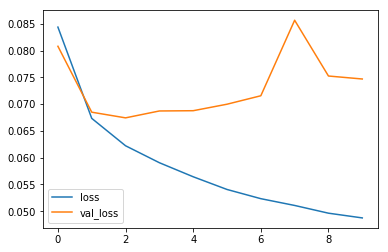

In [100]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

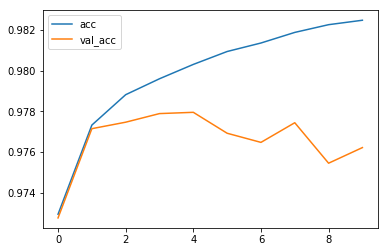

In [101]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [82]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9764695771186963
